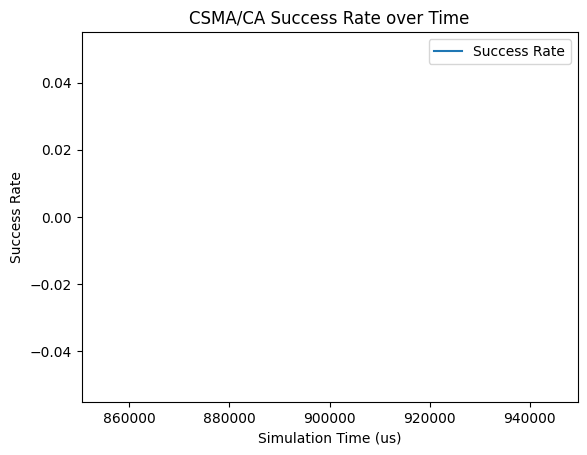

Total Successful Transmissions: 0
Total Collisions: 111112


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

class IEEE80211Simulation:
    def __init__(self):
        # IEEE 802.11ax parameters (in microseconds)
        self.slot_time = 9  # µs
        self.sifs = 16  # µs
        self.difs = 34  # µs (DIFS = SIFS + 2 * slot_time)
        self.cwmin = 16
        self.cwmax = 1024
        
        # Available channels from the image (excluding DFS channels)
        self.available_channels = {
            # UNII-1
            36: {"width": 20, "frequency": 5180},
            40: {"width": 20, "frequency": 5200},
            44: {"width": 20, "frequency": 5220},
            48: {"width": 20, "frequency": 5240},
            
            # UNII-3
            149: {"width": 20, "frequency": 5745},
            153: {"width": 20, "frequency": 5765},
            157: {"width": 20, "frequency": 5785},
            161: {"width": 20, "frequency": 5805},
            165: {"width": 20, "frequency": 5825},
        }
        
        # Maps for wider channel bonding
        self.channel_bonding_40MHz = {
            36: [36, 40],
            44: [44, 48],
            149: [149, 153],
            157: [157, 161]
        }
        
        self.channel_bonding_80MHz = {
            36: [36, 40, 44, 48],
            149: [149, 153, 157, 161]
        }
        
        self.channel_bonding_160MHz = {
            36: [36, 40, 44, 48] + [52, 56, 60, 64]  # Note: 52-64 are DFS in the image
        }
        
        # State variables
        self.stations = {}
        self.channel_status = {ch: {"busy": False, "backoff_counter": -1} for ch in self.available_channels}
        self.simulation_time = 0
        self.max_simulation_time = 1000000  # 1 second in µs
        self.collision_count = 0
        self.successful_transmissions = 0
        self.events = []
        
        # Statistics
        self.throughput_by_channel = defaultdict(int)
        self.channel_usage = defaultdict(int)
        self.backoff_stats = []

    def setup_stations(self, station_counts):
        """
        Set up stations with their primary channels.
        
        Args:
            station_counts: dict mapping channel numbers to number of stations
        """
        station_id = 0
        for channel, count in station_counts.items():
            if channel not in self.available_channels:
                print(f"Warning: Channel {channel} not available, skipping")
                continue
                
            for i in range(count):
                self.stations[station_id] = {
                    "primary_channel": channel,
                    "state": "IDLE",  # IDLE, BACKOFF, TRANSMITTING
                    "backoff_counter": -1,
                    "retry_count": 0,
                    "cw": self.cwmin,
                    "channel_width": 20,  # Default to 20MHz
                    "data_queued": True,  # Assume always has data to send
                    "transmission_time": 0
                }
                station_id += 1
    
    def setup_channel_width(self, station_id, width):
        """
        Set up channel width for a station (20, 40, 80, 160 MHz).
        
        Args:
            station_id: ID of the station
            width: Channel width in MHz (20, 40, 80, 160)
        """
        if station_id not in self.stations:
            print(f"Station {station_id} does not exist")
            return
            
        self.stations[station_id]["channel_width"] = width
    
    def are_channels_idle(self, channels, check_time):
        """Check if all specified channels are idle at the given time."""
        for ch in channels:
            # Skip if channel not available (like DFS channels)
            if ch not in self.available_channels:
                continue
                
            # Check channel status
            if self.channel_status[ch]["busy"] and self.channel_status[ch]["backoff_counter"] > check_time:
                return False
        return True
    
    def get_channels_for_station(self, station_id):
        """Get all channels a station will use based on its primary channel and width."""
        station = self.stations[station_id]
        primary_ch = station["primary_channel"]
        width = station["channel_width"]
        
        if width == 20:
            return [primary_ch]
        elif width == 40:
            for base_ch, channels in self.channel_bonding_40MHz.items():
                if primary_ch in channels:
                    return channels
        elif width == 80:
            for base_ch, channels in self.channel_bonding_80MHz.items():
                if primary_ch in channels:
                    return channels
        elif width == 160:
            for base_ch, channels in self.channel_bonding_160MHz.items():
                if primary_ch in channels:
                    return channels
        
        # Fallback to just primary channel if no bonding is possible
        return [primary_ch]
    
    def start_backoff(self, station_id):
        """Start the backoff procedure for a station."""
        station = self.stations[station_id]
        
        if station["retry_count"] == 0:
            station["cw"] = self.cwmin
        else:
            station["cw"] = min(self.cwmax, station["cw"] * 2)
        
        station["backoff_counter"] = random.randint(0, station["cw"] - 1)
        station["state"] = "BACKOFF"
        
        self.backoff_stats.append(station["backoff_counter"])
    
    def simulate_csma_ca(self):
        """Simulate the CSMA/CA process."""
        self.simulation_time = 0
        
        while self.simulation_time < self.max_simulation_time:
            # Initialize all stations to start backoff if they're idle with data
            for station_id, station in self.stations.items():
                if station["state"] == "IDLE" and station["data_queued"]:
                    self.start_backoff(station_id)
            
            # Process backoffs
            min_backoff = float('inf')
            min_backoff_stations = []
            
            for station_id, station in self.stations.items():
                if station["state"] == "BACKOFF" and station["backoff_counter"] >= 0:
                    channels = self.get_channels_for_station(station_id)
                    
                    # Check if all required channels are idle
                    if self.are_channels_idle(channels, self.simulation_time):
                        if station["backoff_counter"] < min_backoff:
                            min_backoff = station["backoff_counter"]
                            min_backoff_stations = [station_id]
                        elif station["backoff_counter"] == min_backoff:
                            min_backoff_stations.append(station_id)
            
            # If no stations are in backoff, advance time
            if not min_backoff_stations:
                self.simulation_time += self.slot_time
                continue
            
            # Advance time to the minimum backoff
            self.simulation_time += min_backoff * self.slot_time
            
            # Check for collision (multiple stations finished backoff simultaneously)
            if len(min_backoff_stations) > 1:
                self.collision_count += 1
                for station_id in min_backoff_stations:
                    self.stations[station_id]["retry_count"] += 1
                    self.start_backoff(station_id)
            else:
                # Successful transmission
                station_id = min_backoff_stations[0]
                station = self.stations[station_id]
                
                # Calculate transmission time (simplified)
                # Using basic data rate of 54 Mbps for a 1500 byte packet
                # 1500 bytes * 8 bits/byte / 54 Mbps = ~222 µs
                tx_time = 222  
                
                # Mark channels as busy during transmission
                channels = self.get_channels_for_station(station_id)
                for ch in channels:
                    if ch in self.available_channels:  # Skip DFS channels
                        self.channel_status[ch]["busy"] = True
                        self.channel_status[ch]["backoff_counter"] = self.simulation_time + tx_time
                        self.channel_usage[ch] += tx_time
                
                # Update station state
                station["state"] = "TRANSMITTING"
                station["transmission_time"] = self.simulation_time + tx_time
                
                # Log event
                self.events.append({
                    "time": self.simulation_time,
                    "type": "transmission",
                    "station": station_id,
                    "channels": channels,
                    "width": station["channel_width"]
                })
                
                # Update throughput statistics
                primary_ch = station["primary_channel"]
                self.throughput_by_channel[primary_ch] += 1500 * 8  # bits
                
                # Update counter
                self.successful_transmissions += 1
                
                # Advance time for transmission + SIFS + ACK
                self.simulation_time += tx_time + self.sifs + 44  # 44µs for ACK
                
                # Update station after transmission
                station["state"] = "IDLE"
                station["retry_count"] = 0
                station["backoff_counter"] = -1
                
                # Reset channel status after transmission
                for ch in channels:
                    if ch in self.available_channels:
                        self.channel_status[ch]["busy"] = False
            
            # Decrement backoff counters for other stations
            for station_id, station in self.stations.items():
                if station["state"] == "BACKOFF" and station["backoff_counter"] > min_backoff:
                    station["backoff_counter"] -= min_backoff
        
        # Calculate final throughput (bits per second)
        throughput_bps = {}
        for channel, bits in self.throughput_by_channel.items():
            throughput_bps[channel] = bits / (self.simulation_time / 1000000)  # convert µs to seconds
            
        return {
            "throughput": throughput_bps,
            "collisions": self.collision_count,
            "successful_tx": self.successful_transmissions,
            "channel_utilization": {ch: usage / self.simulation_time for ch, usage in self.channel_usage.items()},
            "avg_backoff": sum(self.backoff_stats) / len(self.backoff_stats) if self.backoff_stats else 0
        }
    
    def visualize_results(self, results):
        """Visualize simulation results."""
        # Plot throughput by channel
        plt.figure(figsize=(12, 8))
        
        plt.subplot(2, 2, 1)
        channels = list(results["throughput"].keys())
        throughputs = list(results["throughput"].values())
        plt.bar(channels, throughputs)
        plt.xlabel('Channel')
        plt.ylabel('Throughput (bps)')
        plt.title('Throughput by Channel')
        plt.grid(True)
        
        # Plot channel utilization
        plt.subplot(2, 2, 2)
        channels = list(results["channel_utilization"].keys())
        utilization = [results["channel_utilization"][ch] * 100 for ch in channels]  # Convert to percentage
        plt.bar(channels, utilization)
        plt.xlabel('Channel')
        plt.ylabel('Utilization (%)')
        plt.title('Channel Utilization')
        plt.grid(True)
        
        # Plot collision statistics
        plt.subplot(2, 2, 3)
        plt.bar(['Successful', 'Collisions'], [results["successful_tx"], results["collisions"]])
        plt.ylabel('Count')
        plt.title('Transmission Statistics')
        plt.grid(True)
        
        # Plot average backoff
        plt.subplot(2, 2, 4)
        plt.text(0.5, 0.5, f'Average Backoff Slots: {results["avg_backoff"]:.2f}', 
                 horizontalalignment='center', verticalalignment='center', fontsize=14)
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

# Example usage
def run_simulation_example():
    # Create simulation
    sim = IEEE80211Simulation()
    
    # Set up stations (example: 5 stations on channel 36, 3 on channel 149)
    station_counts = {36: 5, 40: 2, 44: 1, 48: 3, 149: 3, 153: 2, 157: 2, 161: 1, 165: 1}
    sim.setup_stations(station_counts)
    
    # Set some stations to use wider channels
    sim.setup_channel_width(0, 40)  # Station 0 uses 40MHz
    sim.setup_channel_width(5, 80)  # Station 5 uses 80MHz
    
    # Run simulation
    results = sim.simulate_csma_ca()
    
    # Print results
    print("Simulation Results:")
    print(f"Total successful transmissions: {results['successful_tx']}")
    print(f"Total collisions: {results['collisions']}")
    print(f"Average backoff slots: {results['avg_backoff']:.2f}")
    print("\nThroughput by channel (bps):")
    for ch, throughput in results["throughput"].items():
        print(f"  Channel {ch}: {throughput/1000000:.2f} Mbps")
    
    # Visualize results
    sim.visualize_results(results)

if __name__ == "__main__":
    run_simulation_example()